# Train Random Forest Model (Point Prediction)

This notebook trains a Random Forest model for RUL prediction.

**Phase 1**: Point prediction only - no uncertainty quantification.


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import joblib

# Add project root to path
project_root = Path("/Users/siddhantaggarwal/Desktop/Battery_RUL").resolve()
sys.path.append(str(project_root))

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
# Load dataset with EMD features
processed_dir = project_root / "data" / "processed"
df = pd.read_parquet(processed_dir / "rul_features_with_emd.parquet")

print(f"Dataset shape: {df.shape}")
print(f"\nSplits distribution:")
print(df['split'].value_counts().sort_index())

# Filter out rows with NaN RUL (batteries that didn't reach EOL)
df_clean = df[df['RUL'].notna()].copy()
print(f"\nAfter removing NaN RUL: {len(df_clean)} rows")
print(f"RUL range: [{df_clean['RUL'].min():.1f}, {df_clean['RUL'].max():.1f}] cycles")


Dataset shape: (2750, 190)

Splits distribution:
split
test      589
train    1735
val       426
Name: count, dtype: int64

After removing NaN RUL: 1408 rows
RUL range: [-107.0, 123.0] cycles


In [3]:
# Prepare features and target
exclude_cols = [
    'battery_id', 'filename', 'type', 'start_time', 'test_id', 'uid',
    'split', 'cycle_index', 'EOL_cycle', 'RUL', 'SOH', 'Capacity', 
    'Re', 'Rct', 'ambient_temperature'
]

feature_cols = [c for c in df_clean.columns if c not in exclude_cols]
print(f"Total features: {len(feature_cols)}")
print(f"\nFeature categories:")
emd_features = [c for c in feature_cols if '_imf' in c.lower()]
stat_features = [c for c in feature_cols if c not in emd_features]
print(f"  - Statistical features: {len(stat_features)}")
print(f"  - EMD features: {len(emd_features)}")

# Create feature matrix and target
X = df_clean[feature_cols].fillna(0)
y = df_clean['RUL'].values

# Split by battery (already done in dataset)
train_idx = df_clean['split'] == 'train'
val_idx = df_clean['split'] == 'val'
test_idx = df_clean['split'] == 'test'

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

print(f"\nTrain: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(f"Train RUL stats: mean={y_train.mean():.2f}, std={y_train.std():.2f}")


Total features: 175

Feature categories:
  - Statistical features: 16
  - EMD features: 159

Train: 1158, Val: 0, Test: 250
Train RUL stats: mean=-0.25, std=44.31


In [4]:
# Train Random Forest for point prediction using GridSearchCV for hyperparameter optimization
print("Training Random Forest model...")
print("Performing GridSearchCV to find best hyperparameters...")

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Base Random Forest model
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform GridSearchCV with cross-validation
print("Starting GridSearchCV (this may take a few minutes)...")
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # Use MAE as scoring metric
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Get best model
rf_model = grid_search.best_estimator_

print(f"\n✅ GridSearchCV completed!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score (MAE): {-grid_search.best_score_:.2f} cycles")
print("✅ Model trained with optimized hyperparameters!")

# Point predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Handle validation set (may be empty after filtering)
if len(X_val) > 0:
    y_val_pred = rf_model.predict(X_val)
    print(f"✅ Validation set has {len(X_val)} samples")
else:
    print("⚠️  Validation set is empty after filtering NaN RUL values")
    print("   This happens when validation batteries didn't reach EOL (SOH <= 0.8)")
    print("   This is acceptable - we'll use train/test splits only")
    y_val_pred = np.array([])

# Metrics calculation function
def calculate_metrics(y_true, y_pred, name):
    if len(y_pred) == 0:
        print(f"\n{name} Metrics: No data available (skipped)")
        return {'mae': np.nan, 'rmse': np.nan, 'r2': np.nan, 'mape': np.nan}
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-6))) * 100
    
    print(f"\n{name} Metrics:")
    print(f"  MAE:  {mae:.2f} cycles")
    print(f"  RMSE: {rmse:.2f} cycles")
    print(f"  R²:   {r2:.3f}")
    print(f"  MAPE: {mape:.2f}%")
    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape}

# Calculate metrics
train_metrics = calculate_metrics(y_train, y_train_pred, "Train")
if len(X_val) > 0:
    val_metrics = calculate_metrics(y_val, y_val_pred, "Validation")
else:
    val_metrics = {'mae': np.nan, 'rmse': np.nan, 'r2': np.nan, 'mape': np.nan}
    print("\n⚠️  Skipping validation metrics (empty set)")
test_metrics = calculate_metrics(y_test, y_test_pred, "Test")


Training Random Forest model...
Performing GridSearchCV to find best hyperparameters...
Starting GridSearchCV (this may take a few minutes)...
Fitting 5 folds for each of 405 candidates, totalling 2025 fits

✅ GridSearchCV completed!
Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best CV score (MAE): 24.74 cycles
✅ Model trained with optimized hyperparameters!
⚠️  Validation set is empty after filtering NaN RUL values
   This happens when validation batteries didn't reach EOL (SOH <= 0.8)
   This is acceptable - we'll use train/test splits only

Train Metrics:
  MAE:  6.78 cycles
  RMSE: 8.69 cycles
  R²:   0.962
  MAPE: 7030434.88%

⚠️  Skipping validation metrics (empty set)

Test Metrics:
  MAE:  18.82 cycles
  RMSE: 23.61 cycles
  R²:   0.244
  MAPE: 37254401.46%


Top 15 Most Important Features:
               feature  importance
            coulomb_Ah    0.095017
          voltage_mean    0.080933
           current_std    0.039863
              temp_std    0.037094
             temp_mean    0.034999
voltage_drop_rate_mean    0.034096
            duration_s    0.029051
      voltage_imf1_min    0.027682
 voltage_imf1_kurtosis    0.024646
      current_mean_abs    0.022884
   current_imf1_energy    0.022116
           voltage_std    0.021780
      current_imf2_max    0.021601
      current_imf2_min    0.021162
  temperature_imf1_max    0.020675


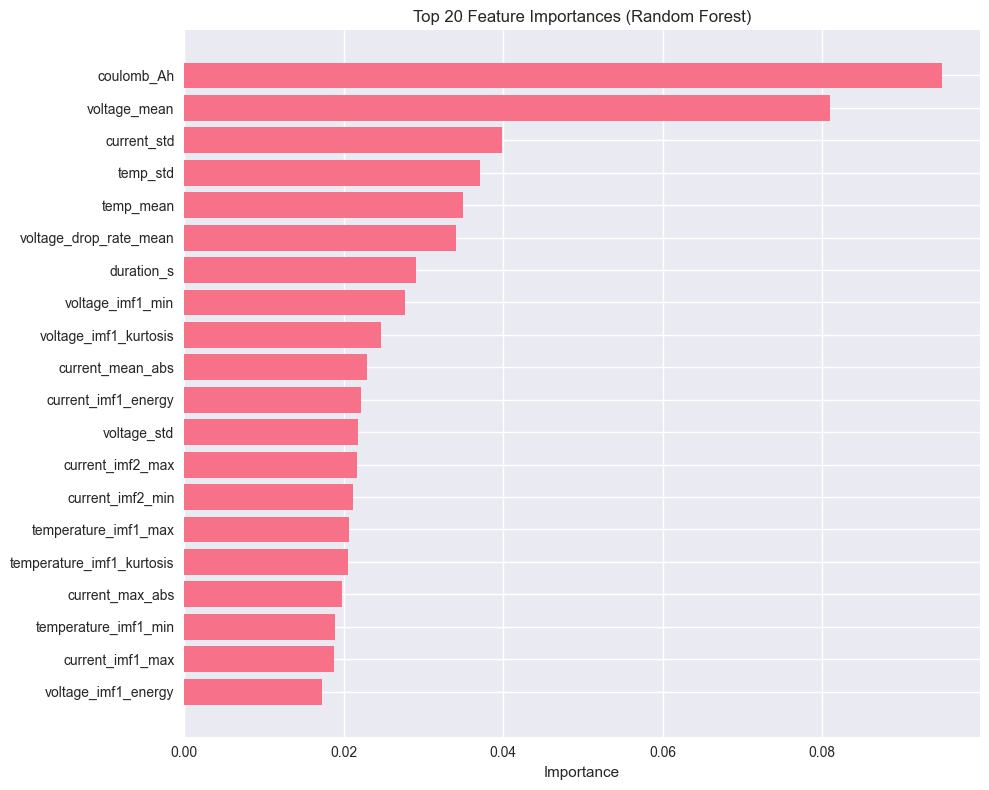

In [5]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 8))
top_n = 20
top_features = feature_importance.head(top_n)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


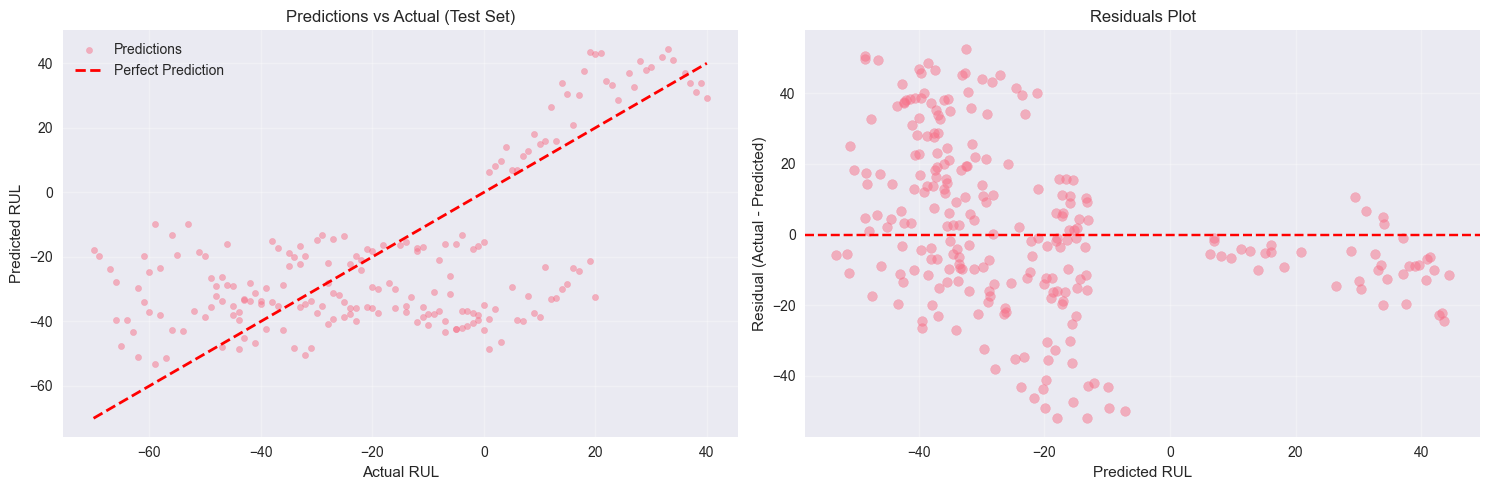

In [6]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Predictions vs Actual
sample_idx = np.random.choice(len(y_test), min(200, len(y_test)), replace=False)
sorted_idx = np.argsort(y_test[sample_idx])

axes[0].scatter(y_test[sample_idx][sorted_idx], y_test_pred[sample_idx][sorted_idx], 
                alpha=0.5, s=20, label='Predictions')
axes[0].plot([y_test[sample_idx].min(), y_test[sample_idx].max()], 
             [y_test[sample_idx].min(), y_test[sample_idx].max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual RUL')
axes[0].set_ylabel('Predicted RUL')
axes[0].set_title('Predictions vs Actual (Test Set)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals plot
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted RUL')
axes[1].set_ylabel('Residual (Actual - Predicted)')
axes[1].set_title('Residuals Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [7]:
# Save model and results
models_dir = project_root / "results" / "models"
models_dir.mkdir(parents=True, exist_ok=True)

# Save the model
model_path = models_dir / "random_forest_rul_point_model.pkl"
joblib.dump(rf_model, model_path)
print(f"✅ Saved model: {model_path}")

# Save predictions
results = pd.DataFrame({
    'battery_id': df_clean.loc[test_idx, 'battery_id'].values,
    'cycle_index': df_clean.loc[test_idx, 'cycle_index'].values,
    'actual_rul': y_test,
    'predicted_rul': y_test_pred,
})

results_path = models_dir / "rf_predictions_point.csv"
results.to_csv(results_path, index=False)
print(f"✅ Saved predictions: {results_path}")

# Save metrics
metrics = pd.DataFrame({
    'metric': ['MAE', 'RMSE', 'R²', 'MAPE'],
    'train': [train_metrics['mae'], train_metrics['rmse'], train_metrics['r2'], train_metrics['mape']],
    'val': [val_metrics['mae'], val_metrics['rmse'], val_metrics['r2'], val_metrics['mape']],
    'test': [test_metrics['mae'], test_metrics['rmse'], test_metrics['r2'], test_metrics['mape']]
})

metrics_path = models_dir / "rf_metrics_point.csv"
metrics.to_csv(metrics_path, index=False)
print(f"✅ Saved metrics: {metrics_path}")

print(f"\n📊 Summary:")
print(f"   Test MAE: {test_metrics['mae']:.2f} cycles")
print(f"   Test RMSE: {test_metrics['rmse']:.2f} cycles")
print(f"   Test R²: {test_metrics['r2']:.3f}")
print(f"\n✅ Phase 1 Complete: Random Forest point prediction model saved!")
print(f"   Next: Train LSTM and Transformer models, then compare all 3.")


✅ Saved model: /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/random_forest_rul_point_model.pkl
✅ Saved predictions: /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/rf_predictions_point.csv
✅ Saved metrics: /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/rf_metrics_point.csv

📊 Summary:
   Test MAE: 18.82 cycles
   Test RMSE: 23.61 cycles
   Test R²: 0.244

✅ Phase 1 Complete: Random Forest point prediction model saved!
   Next: Train LSTM and Transformer models, then compare all 3.
